Doctor's Consultation Fees Prediction
Problem Statement:
Predict A Doctor's Consultation Fee 



We have all been in situation where we go to a doctor in emergency and find that the consultation fees are too high. As a data scientist we all should do better. What if you have data that records important details about a doctor and you get to build a model to predict the doctor’s consulting fee.? This is the use case that let's you do that. 

Size of training set: 5961 records

Size of test set: 1987 records



FEATURES:

Qualification: Qualification and degrees held by the doctor

Experience: Experience of the doctor in number of years

Rating: Rating given by patients

Profile: Type of the doctor

Miscellaneous_Info: Extra information about the doctor

Fees: Fees charged by the doctor (Target Variable)

Place: Area and the city where the doctor is located.

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import re
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import make_scorer

# Data Preprocessing

In [14]:
train = pd.read_excel("Final_Train.xlsx")
train.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees
0,"BHMS, MD - Homeopathy",24 years experience,100%,"Kakkanad, Ernakulam",Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100
1,"BAMS, MD - Ayurveda Medicine",12 years experience,98%,"Whitefield, Bangalore",Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350
2,"MBBS, MS - Otorhinolaryngology",9 years experience,NaN,"Mathikere - BEL, Bangalore",ENT Specialist,NaN,300
3,"BSc - Zoology, BAMS",12 years experience,NaN,"Bannerghatta Road, Bangalore",Ayurveda,"Bannerghatta Road, Bangalore ₹250 Available on...",250
4,BAMS,20 years experience,100%,"Keelkattalai, Chennai",Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250


In [15]:
test = pd.read_excel("Final_Test.xlsx")
test.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info
0,MBBS,35 years experience,NaN,"Ghatkopar East, Mumbai",General Medicine,NaN
1,"MBBS, Diploma in Otorhinolaryngology (DLO)",31 years experience,NaN,"West Marredpally, Hyderabad",ENT Specialist,NaN
2,"MBBS, DDVL",40 years experience,70%,"KK Nagar, Chennai",Dermatologists,"70% 4 Feedback KK Nagar, Chennai"
3,BAMS,0 years experience,NaN,"New Ashok Nagar, Delhi",Ayurveda,NaN
4,"BDS, MDS - Conservative Dentistry & Endodontics",16 years experience,100%,"Kanakpura Road, Bangalore",Dentist,General Dentistry Conservative Dentistry Cosme...


In [16]:
df = train.copy()

In [17]:
df.shape

(5961, 7)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5961 entries, 0 to 5960
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Qualification       5961 non-null   object
 1   Experience          5961 non-null   object
 2   Rating              2659 non-null   object
 3   Place               5936 non-null   object
 4   Profile             5961 non-null   object
 5   Miscellaneous_Info  3341 non-null   object
 6   Fees                5961 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 186.3+ KB


All the columns are type of object.

In [19]:
df.isnull().sum()

Qualification            0
Experience               0
Rating                3302
Place                   25
Profile                  0
Miscellaneous_Info    2620
Fees                     0
dtype: int64

Rating and Miscellaneous_Info column contains null values hence we need to replace them.               

In [20]:
df.describe()

,Fees
count,5961.000000
mean,307.944640
std,190.920373
min,5.000000
25%,150.000000
50%,300.000000
75%,500.000000
max,950.000000


In [21]:
# Extract years of experience
df["Experience"] = df["Experience"].str.split()
df["Experience"] = df["Experience"].str[0].astype("int")

The first line of code split the string into a list while the second extract the first element of the list and convert it into an integer.

In [22]:
# Extract cities
df["Place"].fillna("Unknown,Unknown",inplace=True)
df["Place"] = df["Place"].str.split(",")
df["City"] = df["Place"].str[-1]
df["Place"] = df["Place"].str[0]

Next, the “Place” column can be easily processed by separating the City from the area.
Before extraction, I replaced all missing values in this column with the string ‘Unknown, Unknown’ to represent them. 

In [23]:
# Seperate Ratings into bins
df["Rating"].fillna("-99%",inplace=True)
df["Rating"] = df["Rating"].str[:-1].astype("int")
bins = [-99,0,10,20,30,40,50,60,70,80,90,100]
labels = [i for i in range(11)]
df["Rating"] = pd.cut(df["Rating"],bins=bins,labels=labels,include_lowest=True)

Missing values were replaced with -99% to differentiate them. Then, assuming a rating of 91% has no significant difference as a rating of 99%, I grouped them into bins of size 10. Missing values will fall under class 0 while, 0-9% will be class 1, 10–19% will be class 2, so on and so forth.

In [31]:
# Extract relevant qualification
df["Qualification"]=df["Qualification"].str.split(",")
Qualification ={}
for x in df["Qualification"].values:
    for each in x:
        each = each.strip()
        if each in Qualification:
            Qualification[each]+=1
        else:
            Qualification[each]=1

In [32]:
most_qua = sorted(Qualification.items(),key=lambda x:x[1],reverse=True)[:10]
final_qua =[]
for tup in most_qua:
    final_qua.append(tup[0])
for title in final_qua:
    df[title]=0
    
for x,y in zip(df["Qualification"].values,np.array([idx for idx in range(len(df))])):
    for q in x:
        q = q.strip()
        if q in final_qua:
            df[q][y] = 1
df.drop("Qualification",axis=1,inplace=True)

In [33]:
# Get dummies
df = pd.get_dummies(df,columns=["City","Profile"],prefix=["City","Profile"])

In [34]:
df.drop("Miscellaneous_Info",axis=1,inplace=True)

In [46]:
df.head()

,Experience,Rating,Place,Fees,MBBS,BDS,BAMS,BHMS,MD - Dermatology,MS - ENT,...,City_ Mumbai,City_ Thiruvananthapuram,City_Unknown,City_e,Profile_Ayurveda,Profile_Dentist,Profile_Dermatologists,Profile_ENT Specialist,Profile_General Medicine,Profile_Homeopath
0,24,10,Kakkanad,100,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,12,10,Whitefield,350,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,9,0,Mathikere - BEL,300,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,12,0,Bannerghatta Road,250,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,20,10,Keelkattalai,250,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


<AxesSubplot:xlabel='Experience', ylabel='Fees'>

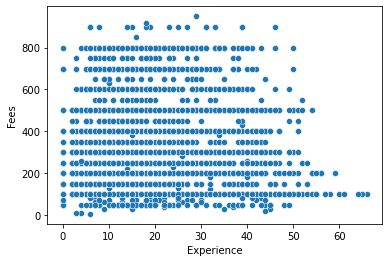

In [47]:
sns.scatterplot(df['Experience'],df['Fees'],data=df)

<AxesSubplot:xlabel='Rating', ylabel='Fees'>

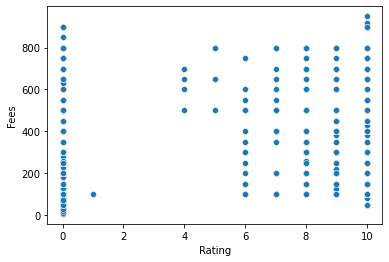

In [48]:
sns.scatterplot(df['Rating'],df['Fees'],data=df)

<AxesSubplot:>

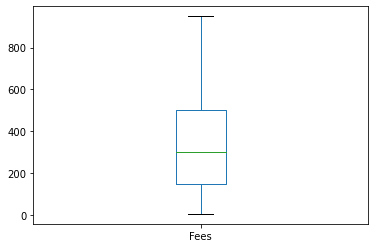

In [50]:
df['Fees'].plot.box()

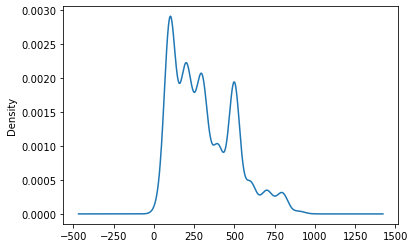

In [51]:
df['Fees'].plot(kind='density')
plt.show()

In [37]:
X = df.drop("Fees",axis=1)
y = df["Fees"]
# Encoding
enc = OrdinalEncoder()
X = enc.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
# feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [38]:
# support vector machine 
from sklearn.svm import SVR
m = SVR(gamma="scale")
m.fit(scaler.transform(X_train),y_train)

SVR()

In [39]:
def score(y_pred,y):
    y_pred = np.log(y_pred)
    y = np.log(y)
    return 1 - ((np.sum((y_pred-y)**2))/len(y))**1/2
# Prediction
y_pred = m.predict(scaler.transform(X_test))
score(y_pred,y_test)

0.7429121308676827

In [42]:
# Define own scorer
scorer = make_scorer(score,greater_is_better=True)
# Hyperparameter tunning
parameters = {"C":[0.1,1,10],"kernel":["linear","rbf","poly"]}
reg = GridSearchCV(m,param_grid=parameters,scoring=scorer,n_jobs=-1,cv=5)
reg.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring=make_scorer(score))

In [43]:
y_pred_tuned = reg.predict(scaler.transform(X_test))
score(y_pred_tuned,y_test)

0.8028913651229435

# Saving Best Model

In [45]:
import joblib
joblib.dump(reg,"PredictDoctorConsultationFee.pkl")

['PredictDoctorConsultationFee.pkl']